In [5]:
# The code was removed by Watson Studio for sharing.

## 1. Create a project access token 

### Projects -> [Your Project name] -> Manage tab -> Access control -> New Access token
#### Give access role to Editor

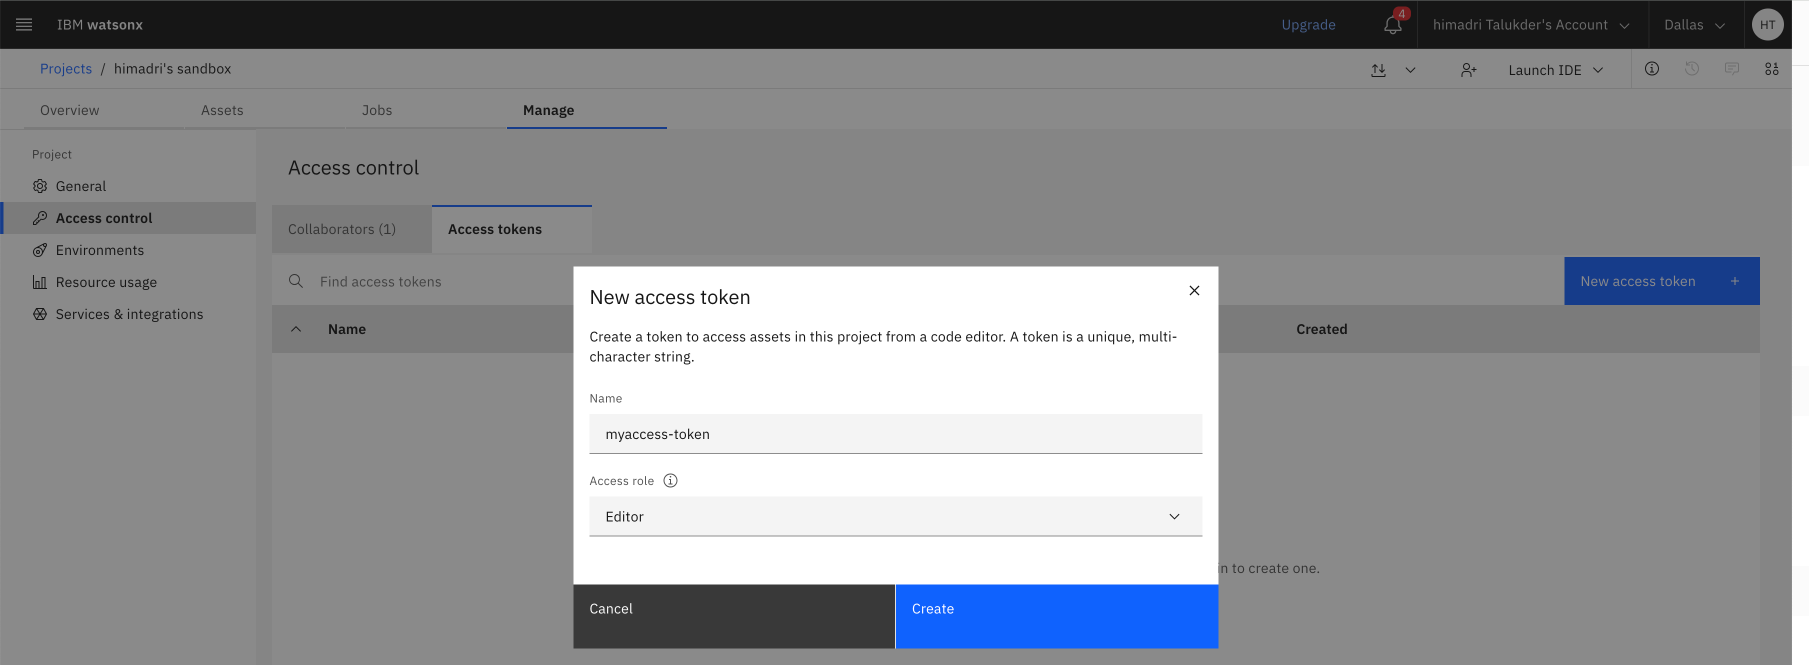

## 2. Insert project token, API key, and region
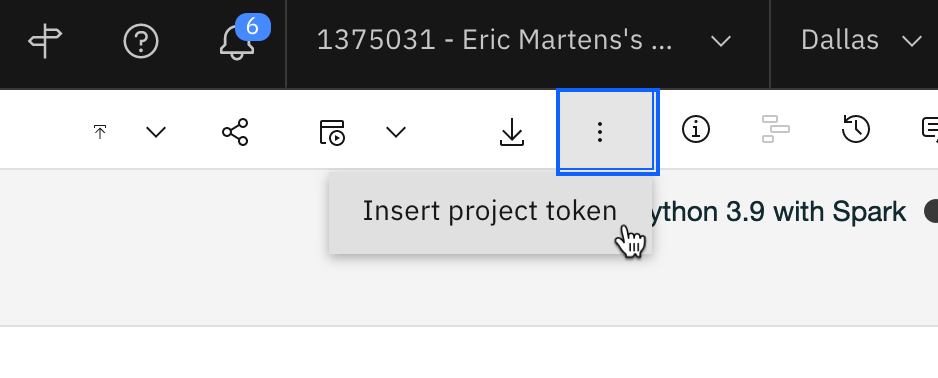

Click the ***three vertical dots*** icon above and select ***Insert project token*** to provide this notebook API access to your project.

Run the newly inserted cell, at the bigging of the notebook


# Train a simple Employee promotion prediction model

## Use Case
This notebook demonstrates the implementation of a Random Forest Classification model for predicting employee promotions. The focus is on leveraging training the model with employee historical data for accurate predictions. Employee promotion prediction involves identifying factors that contribute to promotion decisions based on various features.

## Objective
The primary objective of this notebook is to manually implement an AI Factsheet with `ibm-aigov-facts-client`.

## Table of Contents

1.  [Step 1: Load and prepare the data](#load_data)

1.  [Step 2: Balance the dataset with respect to *is_promoted*](#balance_dataset)

1.  [Step 3: Data Preprocessing and Train-Test split](#process_data)

1.  [Step 4: Train the Random forest classfier model](#train_model)

1.  [Step 5: Model Evaluation](#evaluate_data)

1.  [Step 6: Save the classification model](#save_model)

In [6]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

The **LOCATION** value below will depend on where you provisioned your services. According to the WML Client documentation, valid values for **LOCATION** are:

- Dallas: https://us-south.ml.cloud.ibm.com
- London: https://eu-gb.ml.cloud.ibm.com
- Frankfurt: https://eu-de.ml.cloud.ibm.com
- Tokyo: https://jp-tok.ml.cloud.ibm.com

To create an API key for your user identity in the UI, complete the following steps:

- In the IBM Cloud console, go to Manage > Access (IAM) > API keys.
- Click Create an IBM Cloud API key.
- Enter a name and description for your API key.
- Click Create.
- Then, click Show to display the API key. Or, click Copy to copy and save it for later, or click Download.

In [7]:
API_KEY =  'xxxxxxxxxxxxxxxxxxxxxx'
PROJECT_ID = os.environ['PROJECT_ID']
LOCATION = 'https://us-south.ml.cloud.ibm.com'

In [8]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
    "apikey": API_KEY,
    "url": LOCATION
}

wml_client = APIClient(wml_credentials)
wml_client.set.default_project(PROJECT_ID)

'SUCCESS'

<a id="load_data"></a>
## Step 1: Load and prepare the data

In [9]:
# URL of the CSV file
url = "https://raw.githubusercontent.com/hitalukder/workshop-watsonx.ai/main/ai-factsheet/epp_train.csv"
# Read data from the CSV file into a DataFrame
employee_data = pd.read_csv(url)
# Change the order of the columns
employee_data = employee_data[['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'kpis_met_above_80_percent', 'any_awards_won',
       'avg_training_score', 'is_promoted']]

employee_data = employee_data.drop(columns=["employee_id", "recruitment_channel", "region"])

employee_data.head()

,department,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,kpis_met_above_80_percent,any_awards_won,avg_training_score,is_promoted
0,Sales & Marketing,Bachelor's,f,1,29,NaN,1,0,0,49,0
1,Sales & Marketing,Bachelor's,f,1,30,NaN,1,0,0,50,0
2,Sales & Marketing,Bachelor's,m,1,29,3.0,2,0,0,51,0
3,Sales & Marketing,Bachelor's,f,1,40,3.0,12,0,0,50,0
4,Sales & Marketing,Bachelor's,m,1,45,4.0,5,0,0,50,0


<a id="balance_dataset"></a>
## Step 2: Balance the dataset

Balancing the dataset with respect to the "is_promoted" variable is essential to avoid bias in the predictive model. When the dataset is imbalanced, with one class significantly outnumbering the other (e.g., promoted or not promoted employees), the model may exhibit a tendency to favor the majority class. In the context of employee promotion prediction, imbalance could lead to inaccurate predictions, especially if the majority of instances involve non-promotion.

In [10]:
# Separate the two classes
n = employee_data[employee_data['is_promoted'] == 1].count()[0]
class_0_data = employee_data[employee_data['is_promoted'] == 0]
class_1_data = employee_data[employee_data['is_promoted'] == 1]
print(employee_data['is_promoted'].value_counts())
# Take 3760 samples from class 0
class_0_sampled = class_0_data.sample(n, random_state=42)

# Combine the two classes to create a balanced dataset
employee_data = pd.concat([class_0_sampled, class_1_data])
print(employee_data['is_promoted'].value_counts())


0    50140
1     4668
Name: is_promoted, dtype: int64
0    4668
1    4668
Name: is_promoted, dtype: int64


In [11]:
employee_data.reset_index(drop=True,inplace=True)


<a id="process_data"></a>
## Step 3: Data Preprocessing and Train-Test split
Data preprocessing, including handling missing values, encoding categorical columns, and splitting the dataset into training and test sets, with a check on the class distribution in the training data.

In [12]:
# Handle missing values
employee_data["education"].fillna(employee_data["education"].mode()[0], inplace=True)
employee_data["previous_year_rating"].fillna(1, inplace=True)

# Encode categorical columns
categorical_columns = employee_data.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(employee_data, columns=categorical_columns, drop_first=True)

# Split the data into features (X) and target (y)
y = X_encoded["is_promoted"]
X_encoded = X_encoded.drop("is_promoted", axis=1)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initializing a Random Forest Classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Check the class distribution in the training set
class_counts = y_train.value_counts()
print("Class Distribution in Training Data:")
print(class_counts)

Class Distribution in Training Data:
0    3737
1    3731
Name: is_promoted, dtype: int64


<a id="capture_metadata"></a>
## Step 4: Capture model metadata for AI Governance
Collect the model metadata for effortless report generation using ibm ai governanance python library.

## <span style="color:red">LIKELY ACTION REQUIRED: restart the kernel on error messages</span>

The cell below will install the IBM Factsheets service using the `pip` utility, then authenticate with the IBM Factsheet service using credentials you have already supplied and initialize Factsheet monitoring for this model.

**If you receive an error message from running the cell, you will need to restart the kernel and run all previous cells again**. Due to an issue with different levels of libraries available in the Python and Spark environment, you may receive an error message when importing *ibm_aigov\\_facts\\_client* from the Factsheets library. Restarting the kernel typically fixes this issue, though in rare cases you may have to do it more than once. Click the **Kernel** menu item above and select **Restart**. Once the kernel has restarted, click the **Cell** item and select **Run All Above**. Once those cells have finished executing, run the cell below 

Note that Python notebooks in Watson Studio have full support for `pip install`, which allows you to add whatever libraries you need to the notebook environment. For example, if you wanted to use Python to parse command line arguments, you could run `!pip install argparse`.

In [13]:
!pip uninstall -y ibm-aigov-facts-client
!pip install --upgrade ibm-aigov-facts-client  --no-cache | tail -n 1

from ibm_aigov_facts_client import AIGovFactsClient

Create a new Factsheet client. If you receive an error related to the project access token, it is likely because you either did not insert the project access token as instructed at the beginning of the notebook, or did not run the cell after it was inserted. You will need to return to the beginning of the notebook, ensure the cell is inserted, and execute it.

In [14]:
## factsheet metadata variables, the name of the deployed model
EXPERIMENT_NAME='workshop-hr-usecase-employee-promotion'
PROJECT_UID= os.environ['PROJECT_ID']
CPD_URL=os.environ['RUNTIME_ENV_APSX_URL'][len('https://api.'):]
CONTAINER_ID=PROJECT_ID
CONTAINER_TYPE='project'

PROJECT_ACCESS_TOKEN=project.project_context.accessToken.replace('Bearer ','')
facts_client = AIGovFactsClient(api_key=API_KEY,experiment_name=EXPERIMENT_NAME,container_type=CONTAINER_TYPE,container_id=CONTAINER_ID,set_as_current_experiment=True)
facts_client.assets.get_ai_usecases()

2024/04/10 16:52:20 INFO : Experiment workshop-hr-usecase-employee-promotion does not exist, creating new experiment
2024/04/10 16:52:20 INFO : Experiment successfully created with ID 727089063026018234 and name workshop-hr-usecase-employee-promotion
2024/04/10 16:52:21 INFO : Autolog enabled Successfully


[{
   "model_usecase_id": "626b4d8f-da1c-4399-bcb5-b4e11c0cb8c4",
   "container_type": "catalog",
   "catalog_id": "581bc939-f7e4-4484-bf64-97351f6d01ce"
 },
 {
   "model_usecase_id": "ee77712c-6190-4cf9-b331-36b30e2eee07",
   "container_type": "catalog",
   "catalog_id": "518fb947-be3f-43a9-90e1-7db41fc8ac09"
 },
 {
   "model_usecase_id": "8df049b7-365f-4b2e-8a6a-b1e4e0e5c429",
   "container_type": "catalog",
   "catalog_id": "37750c2e-0481-4745-ad5a-0df021da9757"
 }]

In [15]:
### Prepare ai factsheet meta data
# Create a list to store ColumnInfo objects
column_info_list = []

# Iterate over columns and create ColumnInfo objects
for column_name, dtype in zip(X_train.columns, X_train.dtypes):
    cell = {
        "name": column_name,
        "nullable": True, 
        "metadata": {}, 
        "type": str(dtype)
    }
    column_info_list.append(cell)
    
from ibm_aigov_facts_client.supporting_classes.factsheet_utils import DeploymentDetails,TrainingDataReference,ExternalModelSchemas, ModelDetails
## Specify training reference data
trainingdataref=[
    {
        "id": EXPERIMENT_NAME,
        "type":  "container",
        "connection": {},
        "location": {
                "path": "epp_train.csv",
            },
        "schema": {
                "id": "training_schema",
                "fields": column_info_list
            }
    }
]

The next two cells construct metadata for your model. This will be saved with the model itself and will appear on its Factsheet. If you get errors trying to save the model, they will most likely be from the metadata contained in the model properties, specifically the TYPE and SOFTWARE_SPEC_UID, which frequently change as Watson Studio adds support for new versions of Python, and removes support for outdated versions. You can get a list of current supported specifications by running wml_client.software_specifications.list(). A full list of all supported specifications can be found here.


In [16]:
fields=X_train.columns.tolist()
metadata_dict = {'target_col' : 'is_promoted', 'fields':fields}

In [17]:
software_spec_uid = wml_client.software_specifications.get_id_by_name("runtime-23.1-py3.10")
print("Software Specification ID: {}".format(software_spec_uid))
model_props = {
    wml_client._models.ConfigurationMetaNames.NAME:"{}".format("employee-promotion-ai-factsheet"),
    wml_client._models.ConfigurationMetaNames.TYPE: "scikit-learn_1.1",
    wml_client._models.ConfigurationMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    wml_client._models.ConfigurationMetaNames.TRAINING_DATA_REFERENCES: trainingdataref,
    wml_client._models.ConfigurationMetaNames.LABEL_FIELD: "is_promoted",
    wml_client._models.ConfigurationMetaNames.CUSTOM: metadata_dict
}

facts_client.export_facts.prepare_model_meta(wml_client=wml_client,meta_props=model_props)

Software Specification ID: 336b29df-e0e1-5e7d-b6a5-f6ab722625b2


{'name': 'employee-promotion-ai-factsheet',
 'type': 'scikit-learn_1.1',
 'software_spec': '336b29df-e0e1-5e7d-b6a5-f6ab722625b2',
 'training_data_references': [{'id': 'workshop-hr-usecase-employee-promotion',
   'type': 'container',
   'connection': {},
   'location': {'path': 'epp_train.csv'},
   'schema': {'id': 'training_schema',
    'fields': [{'name': 'no_of_trainings',
      'nullable': True,
      'metadata': {},
      'type': 'int64'},
     {'name': 'age', 'nullable': True, 'metadata': {}, 'type': 'int64'},
     {'name': 'previous_year_rating',
      'nullable': True,
      'metadata': {},
      'type': 'float64'},
     {'name': 'length_of_service',
      'nullable': True,
      'metadata': {},
      'type': 'int64'},
     {'name': 'kpis_met_above_80_percent',
      'nullable': True,
      'metadata': {},
      'type': 'int64'},
     {'name': 'any_awards_won',
      'nullable': True,
      'metadata': {},
      'type': 'int64'},
     {'name': 'avg_training_score',
      'nulla

<a id="train_model"></a>
## Step 5: Train the Random forest classfier model
Initialization, training, and testing of a Random Forest Classifier with balanced class weights for predicting promotions in an employee dataset

In [18]:
# Initialize a Random Forest Classifier with balanced class weights
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=100)

# Training the model
rf_classifier.fit(X_train, y_train)

# Testing data prediction
y_pred = rf_classifier.predict(X_test)

# Traing data prediction
yt_pred = rf_classifier.predict(X_train)

2024/04/10 16:52:27 INFO : logging results to factsheet for run_id 5d62696c7e174252b771300d66448a70
2024/04/10 16:52:27 INFO : Successfully logged results to Factsheet service for run_id 5d62696c7e174252b771300d66448a70 under asset_id: 776b7e5f-63b5-4fe6-8984-3d057fd782e3 and project_id : 3b46c52a-33b7-494d-9db5-266a55ba7818


<a id="evaluate_data"></a>
## Step 6: Model Evaluation
Evaluating the training and testing accuracy scores of a Random Forest Classifier for employee promotion prediction.

In [19]:
# Calculating accuracy
train_accuracy = accuracy_score(y_train, yt_pred)

print("train_accuracy",train_accuracy)

test_accuracy = accuracy_score(y_test, y_pred)

print("test_accuracy",test_accuracy)

train_accuracy 0.9954472415640064
test_accuracy 0.7922912205567452


In [20]:
#testing data 
pred_df={'no_of_trainings': {0: 1,
  1: 1,
  2: 1,
  3: 2,
  4: 1,
  5: 2,
  6: 1,
  7: 1,
  8: 1,
  9: 1},
 'age': {0: 35, 1: 30, 2: 34, 3: 39, 4: 45, 5: 31, 6: 31, 7: 33, 8: 28, 9: 32},
 'previous_year_rating': {0: 5.0,
  1: 5.0,
  2: 3.0,
  3: 1.0,
  4: 3.0,
  5: 3.0,
  6: 3.0,
  7: 3.0,
  8: 4.0,
  9: 5.0},
 'length_of_service': {0: 8,
  1: 4,
  2: 7,
  3: 10,
  4: 2,
  5: 7,
  6: 5,
  7: 6,
  8: 5,
  9: 5},
 'kpis_met_above_80_percent': {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1},
 'any_awards_won': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 'avg_training_score': {0: 49,
  1: 60,
  2: 50,
  3: 50,
  4: 73,
  5: 85,
  6: 59,
  7: 63,
  8: 83,
  9: 54},
 'department_Finance': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_HR': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 'department_Legal': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_Operations': {0: 0,
  1: 1,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 1,
  7: 1,
  8: 0,
  9: 0},
 'department_Procurement': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_R&D': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_Sales & Marketing': {0: 1,
  1: 0,
  2: 1,
  3: 1,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 1},
 'department_Technology': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 1,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'education_Below Secondary': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 "education_Master's & above": {0: 1,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 1,
  8: 0,
  9: 1},
 'gender_m': {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1}}
pred_df=pd.DataFrame(pred_df)
# pred_df

In [21]:
y_prob = rf_classifier.predict_proba(pred_df)
y_prob

array([[0.42      , 0.58      ],
       [0.85      , 0.15      ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.84      , 0.16      ],
       [0.78666667, 0.21333333],
       [0.99      , 0.01      ],
       [0.96      , 0.04      ],
       [0.86      , 0.14      ],
       [0.745     , 0.255     ]])

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Compute precision
precision = precision_score(y_test, y_pred)
print(precision)

# Compute recall
recall = recall_score(y_test, y_pred)
print(recall)

# Compute F1-score
f1 = f1_score(y_test, y_pred)
print(f1)

0.7693817468105987
0.8367129135538954
0.801635991820041


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       931
           1       0.77      0.84      0.80       937

    accuracy                           0.79      1868
   macro avg       0.79      0.79      0.79      1868
weighted avg       0.79      0.79      0.79      1868

F1 Score: 0.80
Recall: 0.84
Precision: 0.77
AUC Score: 0.88


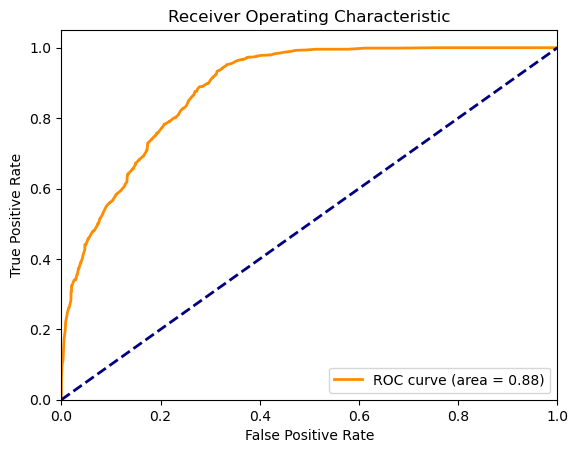

In [23]:
# Get predicted probabilities for class 1
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# custom_threshold = 0.4  # You can adjust this value
# y_pred = (y_prob >= custom_threshold).astype(int)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# AUC Score
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Next cell writes the URL and other info on this notebook as custom data to the Factsheet. Note that any data can be written to the Factsheet that might be helpful for model validators.


In [24]:
#Defining Notebook URL
nb_name = "1-model-training-with-factsheet"
nb_asset_id = "tbd" ##"035cc9c6-1867-49c9-9d45-cf9d56c3e691"
nb_asset_url = "https://" + CPD_URL + "/analytics/notebooks/v2/" + nb_asset_id + "?projectid=" + PROJECT_UID + "&context=cpdaas"

latestRunId = facts_client.runs.get_current_run_id()
facts_client.runs.set_tags(latestRunId, {"Notebook name": nb_name, "Notebook id": nb_asset_id, "Notebook URL" : nb_asset_url})
facts_client.export_facts.export_payload(latestRunId)

2024/04/10 16:52:28 INFO : Initiating logging to factsheet for run_id......5d62696c7e174252b771300d66448a70
2024/04/10 16:52:29 INFO : Successfully logged results to Factsheet service for run_id 5d62696c7e174252b771300d66448a70 under asset_id: 776b7e5f-63b5-4fe6-8984-3d057fd782e3 and project_id : 3b46c52a-33b7-494d-9db5-266a55ba7818


<a id="save_model"></a>
## Step 7: Save the model
Saving a trained Random Forest Classifier model to a file and uploading it as a project asset for future use.

Finally, the model is stored to the project with all of the metadata defined above. Again, if you get errors trying to save the model, they will most likely be from the metadata contained in the model properties, specifically the TYPE and SOFTWARE_SPEC_UID from the code roughly seven code cells above, which frequently change as Watson Studio adds support for new versions of Python, and removes support for outdated versions. You can get a list of current supported specifications by running `wml_client.software_specifications.list()`.

In [25]:
print("Storing model...")
published_model_details = wml_client.repository.store_model(
    model=rf_classifier, 
    meta_props=model_props,
    training_target=['is_promoted'],
    training_data=X_train)
model_uid = wml_client.repository.get_model_id(published_model_details)

print("Done")
print("Model ID: {}".format(model_uid))

Storing model...
Done
Model ID: 4a1047e0-7a54-4a89-b05a-2ea315ec1532


#### Please return to the instruction in [github `step 4`](https://github.com/hitalukder/workshop-watsonx.ai/blob/main/ai-factsheet/readme.md#step_4)